In [2]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.preprocessing import MinMaxScaler

In [3]:
# Step 1: Fetch Real-Time Stock Data
def fetch_stock_data(ticker, start, end):
    df = yf.download(ticker, start=start, end=end)
    return df[['Close']]

In [27]:
df

Price,Close
Ticker,AAPL
Date,
2023-01-03,123.632523
2023-01-04,124.907700
2023-01-05,123.583099
2023-01-06,128.130219
2023-01-09,128.654129
...,...
2023-12-22,192.444595
2023-12-26,191.897873


In [29]:
df.head()

Price,Close
Ticker,AAPL
Date,
2023-01-03,123.632523
2023-01-04,124.907700
2023-01-05,123.583099
2023-01-06,128.130219
2023-01-09,128.654129


In [4]:
# Step 2: Prepare Data for LSTM
def prepare_data(df, lookback=60):
    scaler = MinMaxScaler(feature_range=(0,1))
    scaled_data = scaler.fit_transform(df)
    X, y = [], []
    for i in range(lookback, len(scaled_data)):
        X.append(scaled_data[i-lookback:i, 0])
        y.append(scaled_data[i, 0])
    return np.array(X), np.array(y), scaler

In [5]:
# Step 3: Build the LSTM Model
def build_lstm_model(input_shape):
    model = Sequential([
        LSTM(50, return_sequences=True, input_shape=input_shape),
        Dropout(0.2),
        LSTM(50, return_sequences=False),
        Dropout(0.2),
        Dense(25),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

In [6]:
# Fetch data
ticker = 'AAPL'  # Change as needed
df = fetch_stock_data(ticker, start='2023-01-01', end='2024-01-01')

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed


In [7]:
# Prepare data
lookback = 60  # Days for training
X, y, scaler = prepare_data(df, lookback)
X = X.reshape((X.shape[0], X.shape[1], 1))

In [8]:
# Split into train and test sets
train_size = int(len(X) * 0.8)
X_train, X_test, y_train, y_test = X[:train_size], X[train_size:], y[:train_size], y[train_size:]

In [31]:
# Build and train model
model = build_lstm_model((X_train.shape[1], 1))
model.fit(X_train, y_train, batch_size=32, epochs=10)

Epoch 1/10


C:\Users\anush\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 6s 75ms/step - loss: 0.3032
Epoch 2/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 136ms/step - loss: 0.0388
Epoch 3/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - loss: 0.0227
Epoch 4/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - loss: 0.0248
Epoch 5/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step - loss: 0.0148
Epoch 6/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - loss: 0.0105
Epoch 7/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - loss: 0.0110
Epoch 8/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - loss: 0.0085
Epoch 9/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - loss: 0.0115
Epoch 10/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - loss: 0.0097


In [10]:
# Predict next day's stock price
last_lookback_days = df[-lookback:].values
last_lookback_scaled = scaler.transform(last_lookback_days)
last_lookback_scaled = last_lookback_scaled.reshape(1, lookback, 1)
predicted_price = scaler.inverse_transform(model.predict(last_lookback_scaled))

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 513ms/step


In [11]:
print(f'Predicted Closing Price for Next Day: ${predicted_price[0][0]:.2f}')

Predicted Closing Price for Next Day: $190.90


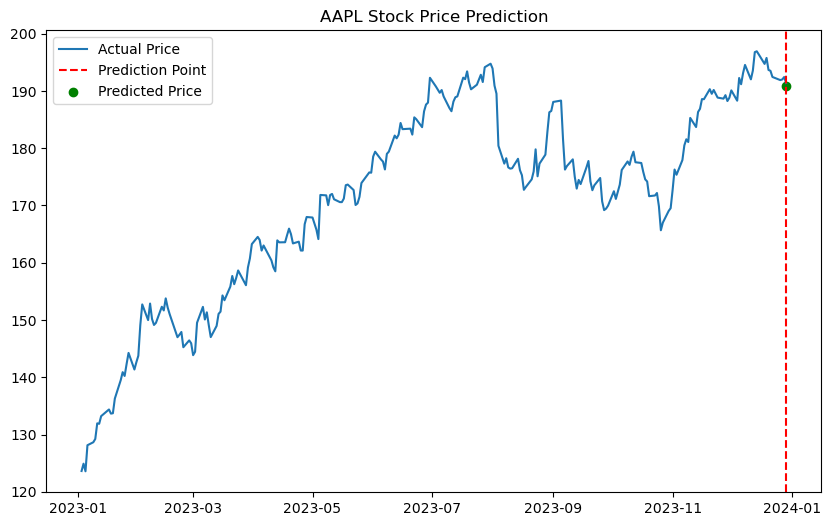

In [12]:
# Plot results
plt.figure(figsize=(10,6))
plt.plot(df.index, df['Close'], label='Actual Price')
plt.axvline(df.index[-1], color='red', linestyle='--', label='Prediction Point')
plt.scatter(df.index[-1], predicted_price[0][0], color='green', label='Predicted Price')
plt.legend()
plt.title(f'{ticker} Stock Price Prediction')
plt.show()

In [13]:
from sklearn.metrics import mean_absolute_percentage_error

# Inverse transform the test predictions
predictions = model.predict(X_test)
predictions = scaler.inverse_transform(predictions.reshape(-1, 1))

# Inverse transform actual y_test values
actual = scaler.inverse_transform(y_test.reshape(-1, 1))

# Assuming predictions and actual are already inverse-transformed
mape = mean_absolute_percentage_error(actual, predictions)
accuracy = 100 - mape * 100

print(f"Mean Absolute Percentage Error (MAPE): {mape * 100:.2f}%")
print(f"Approx. Prediction Accuracy: {accuracy:.2f}%")

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step 
Mean Absolute Percentage Error (MAPE): 2.31%
Approx. Prediction Accuracy: 97.69%
